# Project
**Goal** :
1. write a monte carlo code for AlSc system

In [1]:
from pyiron import Project
import numpy as np
from ase import Atoms
import pandas
import os
import pandas
import matplotlib.pylab as plt
from collections import OrderedDict
from pyiron.base.generic.parameters import GenericParameters
import warnings

In [2]:
pr = Project('MC')
pr.remove_jobs(recursive=True)

# Functions

In [3]:
kb = 8.617333262145e-5

In [5]:
def interactive_monte_carlo(mc_steps, job_name, init_structure, potential, temperature, sc_atoms, pr=pr, period_hdf_rewrite=1000): 
    job = pr.create_job(pr.job_type.Lammps, job_name=job_name)
    job.structure = init_structure
    job.potential = potential
    job.interactive_open() 
    job.calc_minimize()
    job.structure[np.random.choice(len(job.structure), sc_atoms, replace=False)] = 'Sc'
    job.run()
    energy_lst = []
    acc_steps = []
    kBT = temperature*8.617e-5
    E_init = job.output.energy_tot[-1]
    E_prev = E_init
    for step in range(mc_steps):
        # copy previous energy and positions
        #E_prev = job.output.energy_tot[-1]
        x_old = job.structure.positions.copy()
        x_new = x_old.copy()
        # Swap positions of Al and Sc
        Al_ID = np.random.choice(np.arange(len(job.structure))[job.structure.get_chemical_symbols()=='Al'])
        Sc_ID = np.random.choice(np.arange(len(job.structure))[job.structure.get_chemical_symbols()=='Sc'])
        x_new[Al_ID], x_new[Sc_ID] = x_old[Sc_ID], x_old[Al_ID]
        job.structure.positions = x_new
        job.run()
        E_new = job.output.energy_tot[-1]
        dE = E_new-E_prev
        P = np.exp(-dE/kBT)
        if np.random.rand() < P:
            # accept
            acc_steps.append(step)
            print('Step : ', step, 'Energy : ', E_new)
            energy_lst.append(E_new)
            E_prev = E_new
        else:
            # Swap back
            job.structure.positions = x_old
            #job.run()
        if step>1 and step % period_hdf_rewrite == 0:
            print('step', step,'hdf_rewriting')
            job.project_hdf5.rewrite_hdf5(job.job_name)
            job.structure.positions = x_old
            job.run()
    job.interactive_close() 
    return energy_lst, acc_steps

# Interactive MC

In [6]:
lattice_zeroK_al = 4.04
al_structure = pr.create_structure(element="Al", lattice_constant=lattice_zeroK_al, bravais_basis="fcc").repeat(5)

In [9]:
potential = job.list_potentials()[-1]

,Config,Filename,Model,Name,Species
0,"[pair_style eam/alloy \n, pair_coeff * * /cmmc/u/aaslam/potential.dat Al Sc \n]",[],eam/alloy,my_potential,"[Al, Sc]"


In [24]:
acc_steps, Energy = interactive_monte_carlo(mc_steps=30000, job_name='interactive_test', init_structure=al_structure,
                                 potential=potential, temperature=600, sc_atoms=10)

The job interactive_test was saved and received the ID: 5558651
Step :  0 Energy :  -1692.2156969932585
Step :  2 Energy :  -1692.21848309121
Step :  3 Energy :  -1692.6438431111756
Step :  6 Energy :  -1692.6357119388429
Step :  10 Energy :  -1692.6381095355096
Step :  13 Energy :  -1692.6340003634991
Step :  16 Energy :  -1692.6410512280077
Step :  20 Energy :  -1692.6868476002087
Step :  21 Energy :  -1692.8102098863762
Step :  37 Energy :  -1692.8100665320374
Step :  48 Energy :  -1692.812473384137
Step :  49 Energy :  -1692.8137445146358
Step :  50 Energy :  -1692.811239139521
Step :  59 Energy :  -1692.8148120348458
Step :  63 Energy :  -1692.8109802779538
Step :  65 Energy :  -1692.8203217799069
Step :  73 Energy :  -1692.7772668515936
Step :  75 Energy :  -1692.8184655124226
Step :  76 Energy :  -1692.8129201531046
Step :  77 Energy :  -1692.9347579126231
Step :  79 Energy :  -1692.932051996777
Step :  80 Energy :  -1692.9313504680836
Step :  86 Energy :  -1693.0643950525307
St

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 10% Sc in Al, Temp :600 K, 30 atoms Sc, steps = 30,000

In [39]:
Energy

[-1734.4963119372399,
 -1734.9304973990243,
 -1734.9778533604583,
 -1735.0331043245098,
 -1735.197348007422,
 -1735.1534638340424,
 -1735.372113759925,
 -1735.5962894927281,
 -1735.5895985017248,
 -1735.6025591182206,
 -1735.6572667076332,
 -1735.854902002091,
 -1736.2946149298182,
 -1736.3046417772973,
 -1736.430998685418,
 -1736.7531074233343,
 -1736.8046399525983,
 -1737.0238179711594,
 -1737.2790069563566,
 -1737.3251791587459,
 -1737.6722034657714,
 -1738.2506954500006,
 -1738.2722197963126,
 -1738.389954911242,
 -1738.3860711057384,
 -1738.45449115666,
 -1738.6049452316488,
 -1738.6387191118026,
 -1738.8110913032185,
 -1739.020301868448,
 -1739.0904776978387,
 -1739.2275743568407,
 -1739.1982699642897,
 -1739.2490020569396,
 -1739.2789612442525,
 -1739.298952208038,
 -1739.300234409357,
 -1739.6262108199219,
 -1739.8951248994815,
 -1739.975396543164,
 -1740.0198014283153,
 -1740.4556042820861,
 -1740.6370319713892,
 -1740.7891482189286,
 -1740.9846928527852,
 -1741.079934487638,


Text(0, 0.5, 'Energy eV/atom')

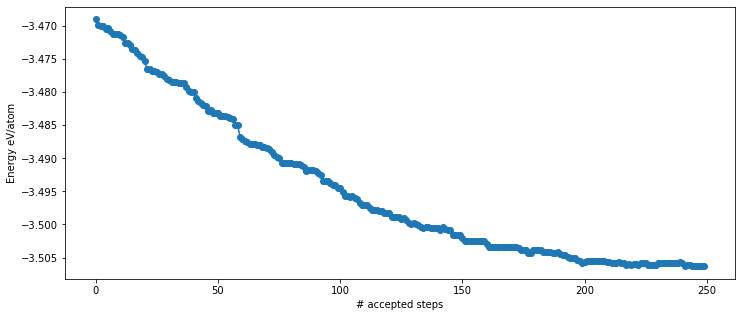

In [40]:
plt.figure(figsize=[12, 5])
plt.plot(np.array(Energy)/500, 'o-')
plt.xlabel('# accepted steps')
plt.ylabel('Energy eV/atom')

# 6% Sc in Al, Temp :600 K, 30 atoms Sc, steps = 30,000

In [87]:
Energy = np.array([-1713.46669926, -1713.7552283 , -1714.13611491, -1714.20134863,
       -1714.39634178, -1714.61670117, -1714.6195441 , -1714.70852992,
       -1714.95778228, -1715.44486696, -1715.56703298, -1715.63216729,
       -1715.82228128, -1715.77080476, -1715.94562186, -1715.99208712,
       -1716.04384236, -1716.29444023, -1716.29805826, -1716.52310715,
       -1716.69968138, -1716.70257544, -1716.78948523, -1716.77867276,
       -1717.03525813, -1717.08496711, -1717.10568872, -1717.25335605,
       -1717.25629993, -1717.35760777, -1717.36225848, -1717.4925043 ,
       -1717.94440255, -1718.03195147, -1718.17963907, -1718.22425432,
       -1718.21561701, -1718.26646695, -1718.35684272, -1718.43259293,
       -1718.43106599, -1718.54737999, -1718.6358092 , -1718.69209688,
       -1718.7806203 , -1719.00878622, -1719.09524708, -1719.09878346,
       -1719.10707532, -1719.06347144, -1719.12373567, -1719.12968766,
       -1719.12993597, -1719.13219693, -1719.25437697, -1719.25719481,
       -1719.25606357, -1719.25288722, -1719.24783596, -1719.253597  ,
       -1719.29687441, -1719.29696163, -1719.30464452, -1719.42244193,
       -1719.43058952, -1719.45935212, -1719.51022294, -1719.63415258,
       -1719.89522273, -1719.92466291, -1720.02388626, -1720.2368303 ,
       -1720.23560944, -1720.22456705, -1720.21500215, -1720.20394026,
       -1720.20923174, -1720.19660043, -1720.32426371, -1720.24163541,
       -1720.32553272, -1720.25498104, -1720.2941743 , -1720.29916003,
       -1720.30298389, -1720.34033192, -1720.33532925, -1720.46246295,
       -1720.46192333, -1720.45084591, -1720.49564908, -1720.4851439 ,
       -1720.48354086, -1720.60932334, -1720.60429036, -1720.60696977,
       -1720.71907519, -1720.72191854, -1720.82139388, -1720.82482646,
       -1720.82230057, -1720.90515329, -1720.98338793, -1721.1816922 ,
       -1721.29954   , -1721.31073726, -1721.30468868, -1721.29039448,
       -1721.35642832, -1721.52537787, -1721.40183087, -1721.44725185,
       -1721.45219715, -1721.44811007, -1721.45437755, -1721.45335731,
       -1721.46826042, -1721.46021832, -1721.51643273, -1721.51313843,
       -1721.51071441, -1721.5053953 , -1721.49453945, -1721.49939395,
       -1721.50443757, -1721.49765911, -1721.62120696, -1721.61370825,
       -1721.73521321, -1721.73936265, -1721.7493474 , -1721.75214603,
       -1721.79569616, -1721.91172453, -1721.91581124, -1721.89971439,
       -1721.915581  , -1721.79206098, -1722.03466496, -1722.02838668,
       -1722.03402852, -1722.15932536, -1722.26764805, -1722.27176781,
       -1722.27819311, -1722.25844034, -1722.26747724, -1722.38313343,
       -1722.38268196, -1722.37565701, -1722.3805068 , -1722.36888947,
       -1722.36290973, -1722.4906014 , -1722.48405736, -1722.35503217,
       -1722.35681596, -1722.35564163, -1722.34906737, -1722.35527684,
       -1722.34475839, -1722.46545932, -1722.45172632, -1722.45011479,
       -1722.44446607, -1722.44543859, -1722.43451352, -1722.43459511,
       -1722.43506349, -1722.68408867, -1722.80520986, -1722.79965529,
       -1722.65934686, -1722.91225719, -1722.90246197, -1722.8812618 ,
       -1722.91211323, -1722.91031368, -1722.91370086, -1722.90663885,
       -1722.90836172, -1723.03452803, -1723.03237942, -1723.27570114,
       -1723.28050923, -1723.27788841, -1723.27735332, -1723.39751581,
       -1723.39545203, -1723.39430388, -1723.39772112, -1723.52258607,
       -1723.51988545, -1723.51981091, -1723.5182008 , -1723.51654971,
       -1723.51667583, -1723.39727192, -1723.76717599, -1723.7691765 ,
       -1723.76781223, -1723.76587263, -1723.7641307 , -1723.76619359,
       -1723.88442882, -1723.88454942, -1723.88535226, -1724.12653935,
       -1724.12475582, -1724.12442585, -1724.12692468, -1724.24619929,
       -1724.24619929, -1724.12569446, -1724.12630287, -1724.24693671,
       -1724.24648478, -1724.24619929, -1724.24680379, -1724.24864161,
       -1724.24626596, -1724.14291806, -1724.12377822, -1724.1217751 ,
       -1724.24648478, -1724.24533464, -1724.24644718, -1724.24778396,
       -1724.24533464, -1724.24684682, -1724.24524741, -1724.24512056,
       -1724.24524741, -1724.24619929, -1724.24774028, -1724.24626596,
       -1724.24574365, -1724.24511774, -1724.24625276, -1724.24644718,
       -1724.24619929, -1724.2481998 , -1724.24603777, -1724.24644718,
       -1724.24648478, -1724.24603777, -1724.24693671, -1724.24630337,
       -1724.24680379, -1724.24574365, -1724.24771923, -1724.24644718,
       -1724.24625276, -1724.24511774, -1724.24771923, -1724.24648478,
       -1724.24728991, -1724.24644718, -1724.24680379, -1724.24524741,
       -1724.24574365, -1724.24549666, -1724.2481998 , -1724.24728991,
       -1724.24774028, -1724.24625276, -1724.24864161, -1724.24540134,
       -1724.24619929, -1724.2481998 , -1724.24540134, -1724.24603777,
       -1724.24473798, -1724.24625276, -1724.24774028, -1724.24644718,
       -1724.24619929, -1724.24829424, -1724.24728531, -1724.24619929,
       -1724.24512056, -1724.24549666, -1724.24693671, -1724.24574365,
       -1724.24524741, -1724.24473798, -1724.24864161])

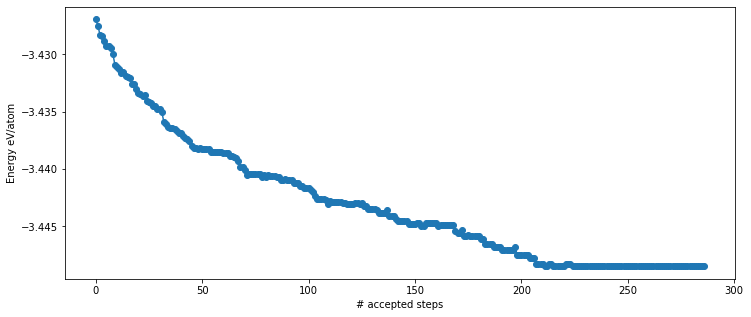

In [89]:
plt.figure(figsize=[12, 5])
plt.plot(np.array(Energy)/500, 'o-')
plt.xlabel('# accepted steps')
plt.ylabel('Energy eV/atom')
plt.savefig('/cmmc/u/aaslam/Images/Montecarlo.png', dpi=150, bbox_inches='tight')